In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.xarray
%matplotlib notebook
x_zero = 0.0437063
y_zero = 0.0434812
z_zero = -0.0437816

# Centre Voltage Sweep

In [2]:
cen_v= pd.read_csv('./2019-06-28/test_daedalus_voltCenter_calib_2019-06-28_3.csv', comment="#")

In [3]:
cen_v_zeroed = cen_v.copy()
cen_v_zeroed.Yfield = cen_v.Yfield-y_zero
cen_v_zeroed.Xfield = cen_v.Xfield-x_zero
cen_v_zeroed.Zfield = cen_v.Zfield-z_zero
cen_vp = cen_v_zeroed[cen_v_zeroed.Yfield>0]
cen_vn = cen_v_zeroed[cen_v_zeroed.Yfield<0]

In [4]:
cen_vp_coeff = np.polyfit(cen_vp.Yfield.values, cen_vp.V.values, 5)
cen_vn_coeff = np.polyfit(cen_vn.Yfield.values, cen_vn.V.values, 5)
cen_v_coeffs = np.asarray([cen_vp_coeff, cen_vn_coeff])
print(cen_v_coeffs)

[[ 4.14321201e+03 -3.09816032e+03  5.39017151e+02 -2.70980929e+01
  -1.86983578e+01  2.31102375e-01]
 [ 5.87373362e+03  4.41288700e+03  8.90495611e+02  6.66585948e+01
  -1.69717233e+01  2.25308449e-01]]


In [5]:
np.savetxt("./icarusCalibCsv/icarus_volt_center_calib.csv", cen_v_coeffs, delimiter=",")

Text(0.5, 1.0, 'B(V)')

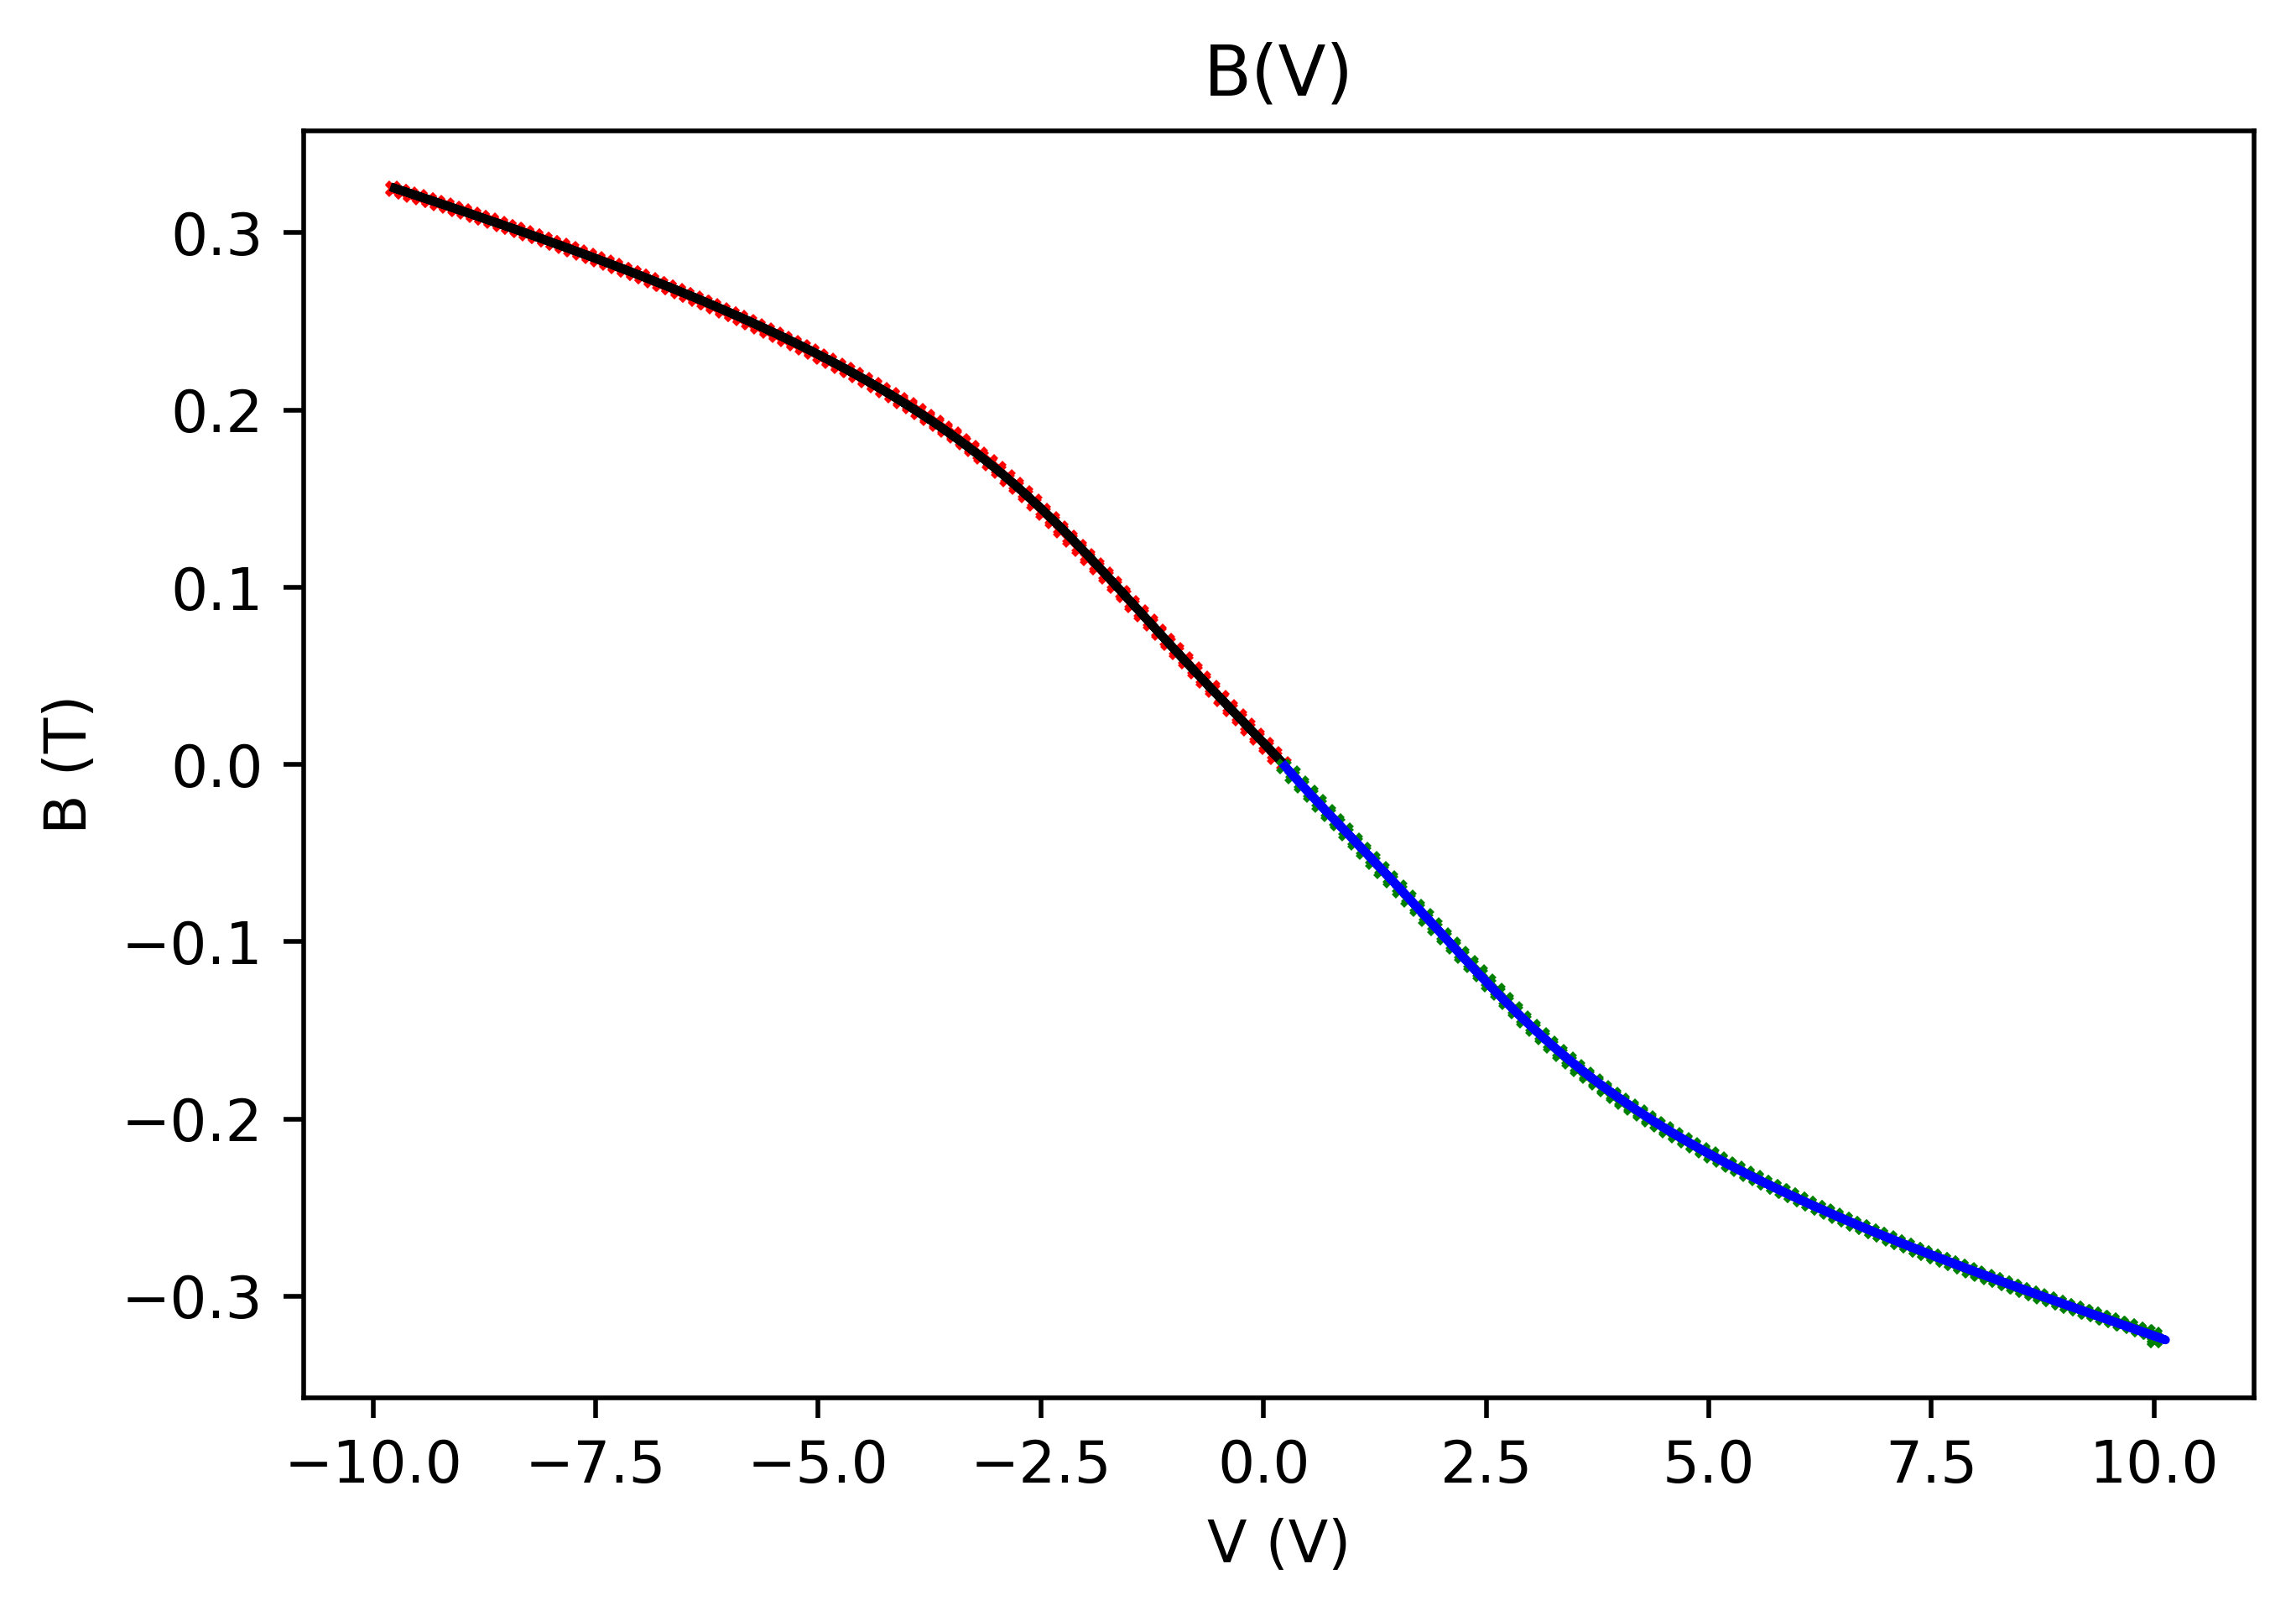

In [6]:
cen_vp_fit = np.poly1d(cen_vp_coeff)
cen_vn_fit = np.poly1d(cen_vn_coeff)
plt.figure(dpi=500)

plt.plot(cen_vp.V, cen_vp.Yfield, 'rx', markersize=2)
plt.plot(cen_vp_fit(cen_vp.Yfield), cen_vp.Yfield , 'k')

plt.plot(cen_vn.V, cen_vn.Yfield, 'gx', markersize=2)
plt.plot(cen_vn_fit(cen_vn.Yfield), cen_vn.Yfield , 'b')
plt.xlabel('V (V)')
plt.ylabel('B (T)')
plt.title('B(V)')

# Radial Calibration 5 V

In [7]:
vp = pd.read_csv('./2019-06-28/5vp_daedalus_radialPolar_calib_A000.0_2019-06-28_2.csv', comment='#')
vn = pd.read_csv('./2019-06-28/5vn_daedalus_radialPolar_calib_A000.0_2019-06-28_1.csv', comment='#')

In [19]:
vp = vp.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp = vp.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Yfield)*180/np.pi)
vp = vp.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vn = vn.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn = vn.assign(theta=lambda a: np.arctan2(a.Zfield, a.Yfield)*180/np.pi)
vn = vn.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

In [20]:
vp_dv = {}
vn_dv = {}
for c in vp.columns[:]:
    vp_dv[c] = (["R"],vp[c])
    vn_dv[c] = (["R"],vn[c])
vp_ds = xr.Dataset(vp_dv)
vn_ds = xr.Dataset(vn_dv)

### OOP field

In [21]:
vp_ds.where(abs(vp_ds.theta) == abs(vp_ds.theta).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 0.01
Data variables:
    Xfield        (R) float64 -0.0001822
    Yfield        (R) float64 -0.2248
    Zfield        (R) float64 5.171e-05
    elapsed_time  (R) float64 1.25e+03
    phi           (R) float64 -180.0
    theta         (R) float64 0.01318
    Bmag          (R) float64 0.2248

In [22]:
vp_ds.where(abs(vn_ds.theta-90.0) == abs(vn_ds.theta-90.0).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 14.43
Data variables:
    Xfield        (R) float64 -0.005237
    Yfield        (R) float64 4.936e-05
    Zfield        (R) float64 -0.1368
    elapsed_time  (R) float64 2.392e+03
    phi           (R) float64 -89.46
    theta         (R) float64 -90.02
    Bmag          (R) float64 0.1368

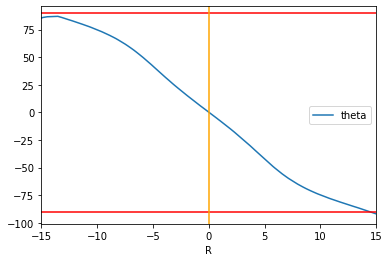

In [23]:
vp.plot('R', 'theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

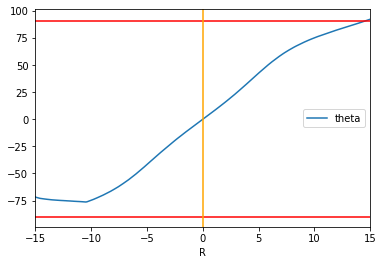

In [24]:
vn.plot('R', 'theta')
plt.axhline(-90,color='r')
plt.axhline(90, color='r')
plt.axvline(0,color='orange')

In [25]:
vp_rp = vp[vp.R>0]
vp_rn = vp[vp.R<0]
vn_rp = vn[vn.R>0]
vn_rn = vn[vn.R<0]

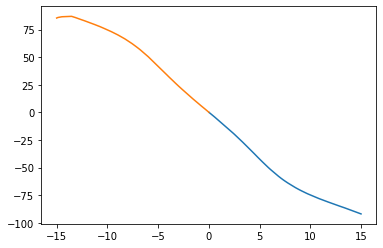

In [26]:
plt.plot(vp_rp.R, vp_rp.theta)
plt.plot(vp_rn.R, vp_rn.theta)

### Positive and Negative field discrepancy is <0.5$^\circ$ 

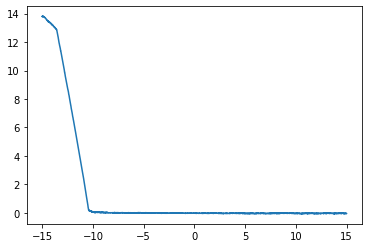

In [27]:
plt.plot(vp.R, (vp.theta+vn.theta))

### Positive voltage R-theta relation

In [30]:
vp_R_thetapos_coeff = np.polyfit(vp_rp.theta, vp_rp.R, 6)
vp_R_thetaneg_coeff = np.polyfit(vp_rn.theta, vp_rn.R, 6)
vp_R_thetapos = np.poly1d(vp_R_thetapos_coeff)
vp_R_thetaneg = np.poly1d(vp_R_thetaneg_coeff)
R_theta = vp_R_thetapos_coeff,vp_R_thetaneg_coeff
print(R_theta)
np.savetxt("./icarusCalibCsv/icarus_radial_polar_calib.csv", R_theta, delimiter=",")

(array([-1.88875574e-10, -4.69977166e-08, -4.12744260e-06, -1.69582896e-04,
       -3.68481506e-03, -1.59453031e-01, -3.74949995e-02]), array([-2.00043896e-10,  4.72499202e-08, -4.47312714e-06,  1.97086483e-04,
       -3.61658550e-03, -1.03509122e-01, -3.55658911e-02]))


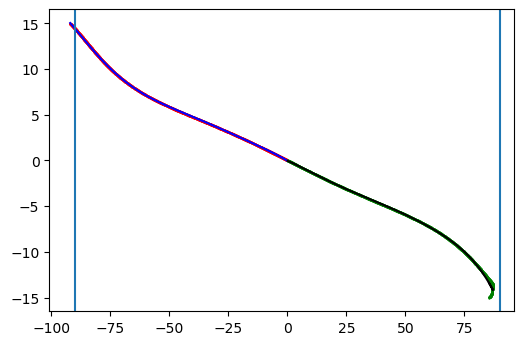

In [31]:
plt.figure(dpi=100)
plt.plot(vp_rp.theta, vp_rp.R, 'r+', markersize=2)
plt.plot(vp_rp.theta, vp_R_thetapos(vp_rp.theta), 'b')
plt.plot(vp_rn.theta, vp_rn.R, 'g+', markersize=2)
plt.plot(vp_rn.theta, vp_R_thetaneg(vp_rn.theta), 'k')
plt.axvline(90)
plt.axvline(-90)

In [32]:
bmag_vp_rp_coeff = np.polyfit(vp[vp.R>0].R, vp[vp.R>0].Bmag, 10)
bmag_vp_rp = np.poly1d(bmag_vp_rp_coeff)

bmag_vp_rn_coeff = np.polyfit(vp[vp.R<0].R, vp[vp.R<0].Bmag, 10)
bmag_vp_rn = np.poly1d(bmag_vp_rn_coeff)

bmag_vn_rp_coeff = np.polyfit(vn[vn.R>0].R, vn[vn.R>0].Bmag, 10)
bmag_vn_rp = np.poly1d(bmag_vn_rp_coeff)

bmag_vn_rn_coeff = np.polyfit(vn[vn.R<0].R, vn[vn.R<0].Bmag, 10)
bmag_vn_rn = np.poly1d(bmag_vn_rn_coeff)

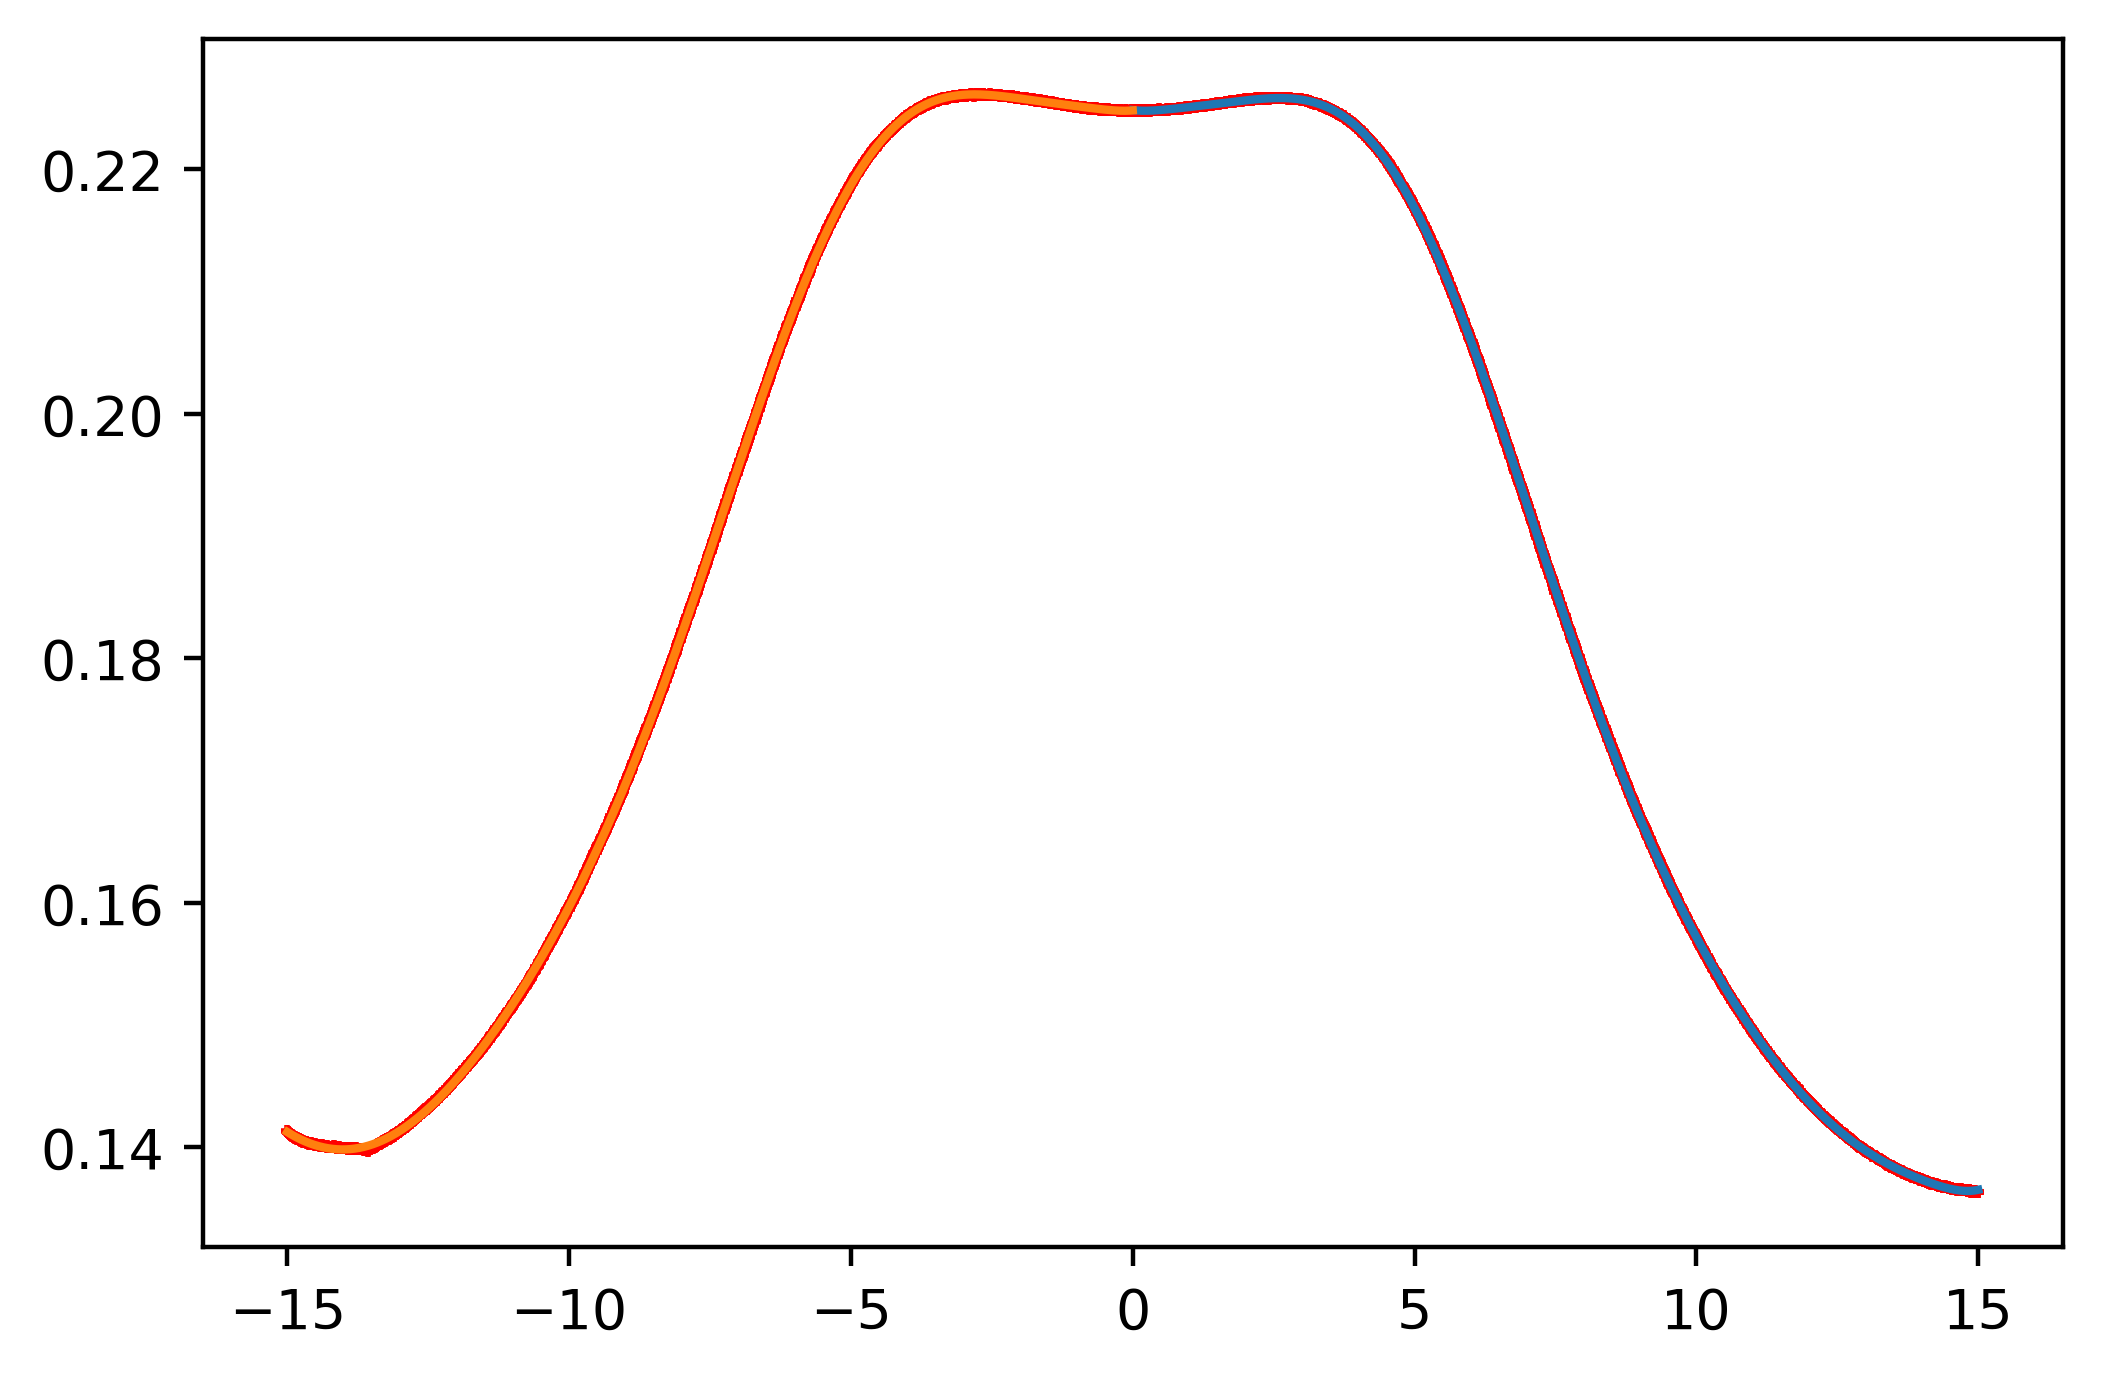

In [35]:
plt.figure(dpi=400)
plt.plot(vp.R, vp.Bmag, 'r+', markersize=2)
plt.plot(vp[vp.R>0].R, bmag_vp_rp(vp[vp.R>0].R))
plt.plot(vp[vp.R<0].R, bmag_vp_rn(vp[vp.R<0].R))
# plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
# plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
# plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

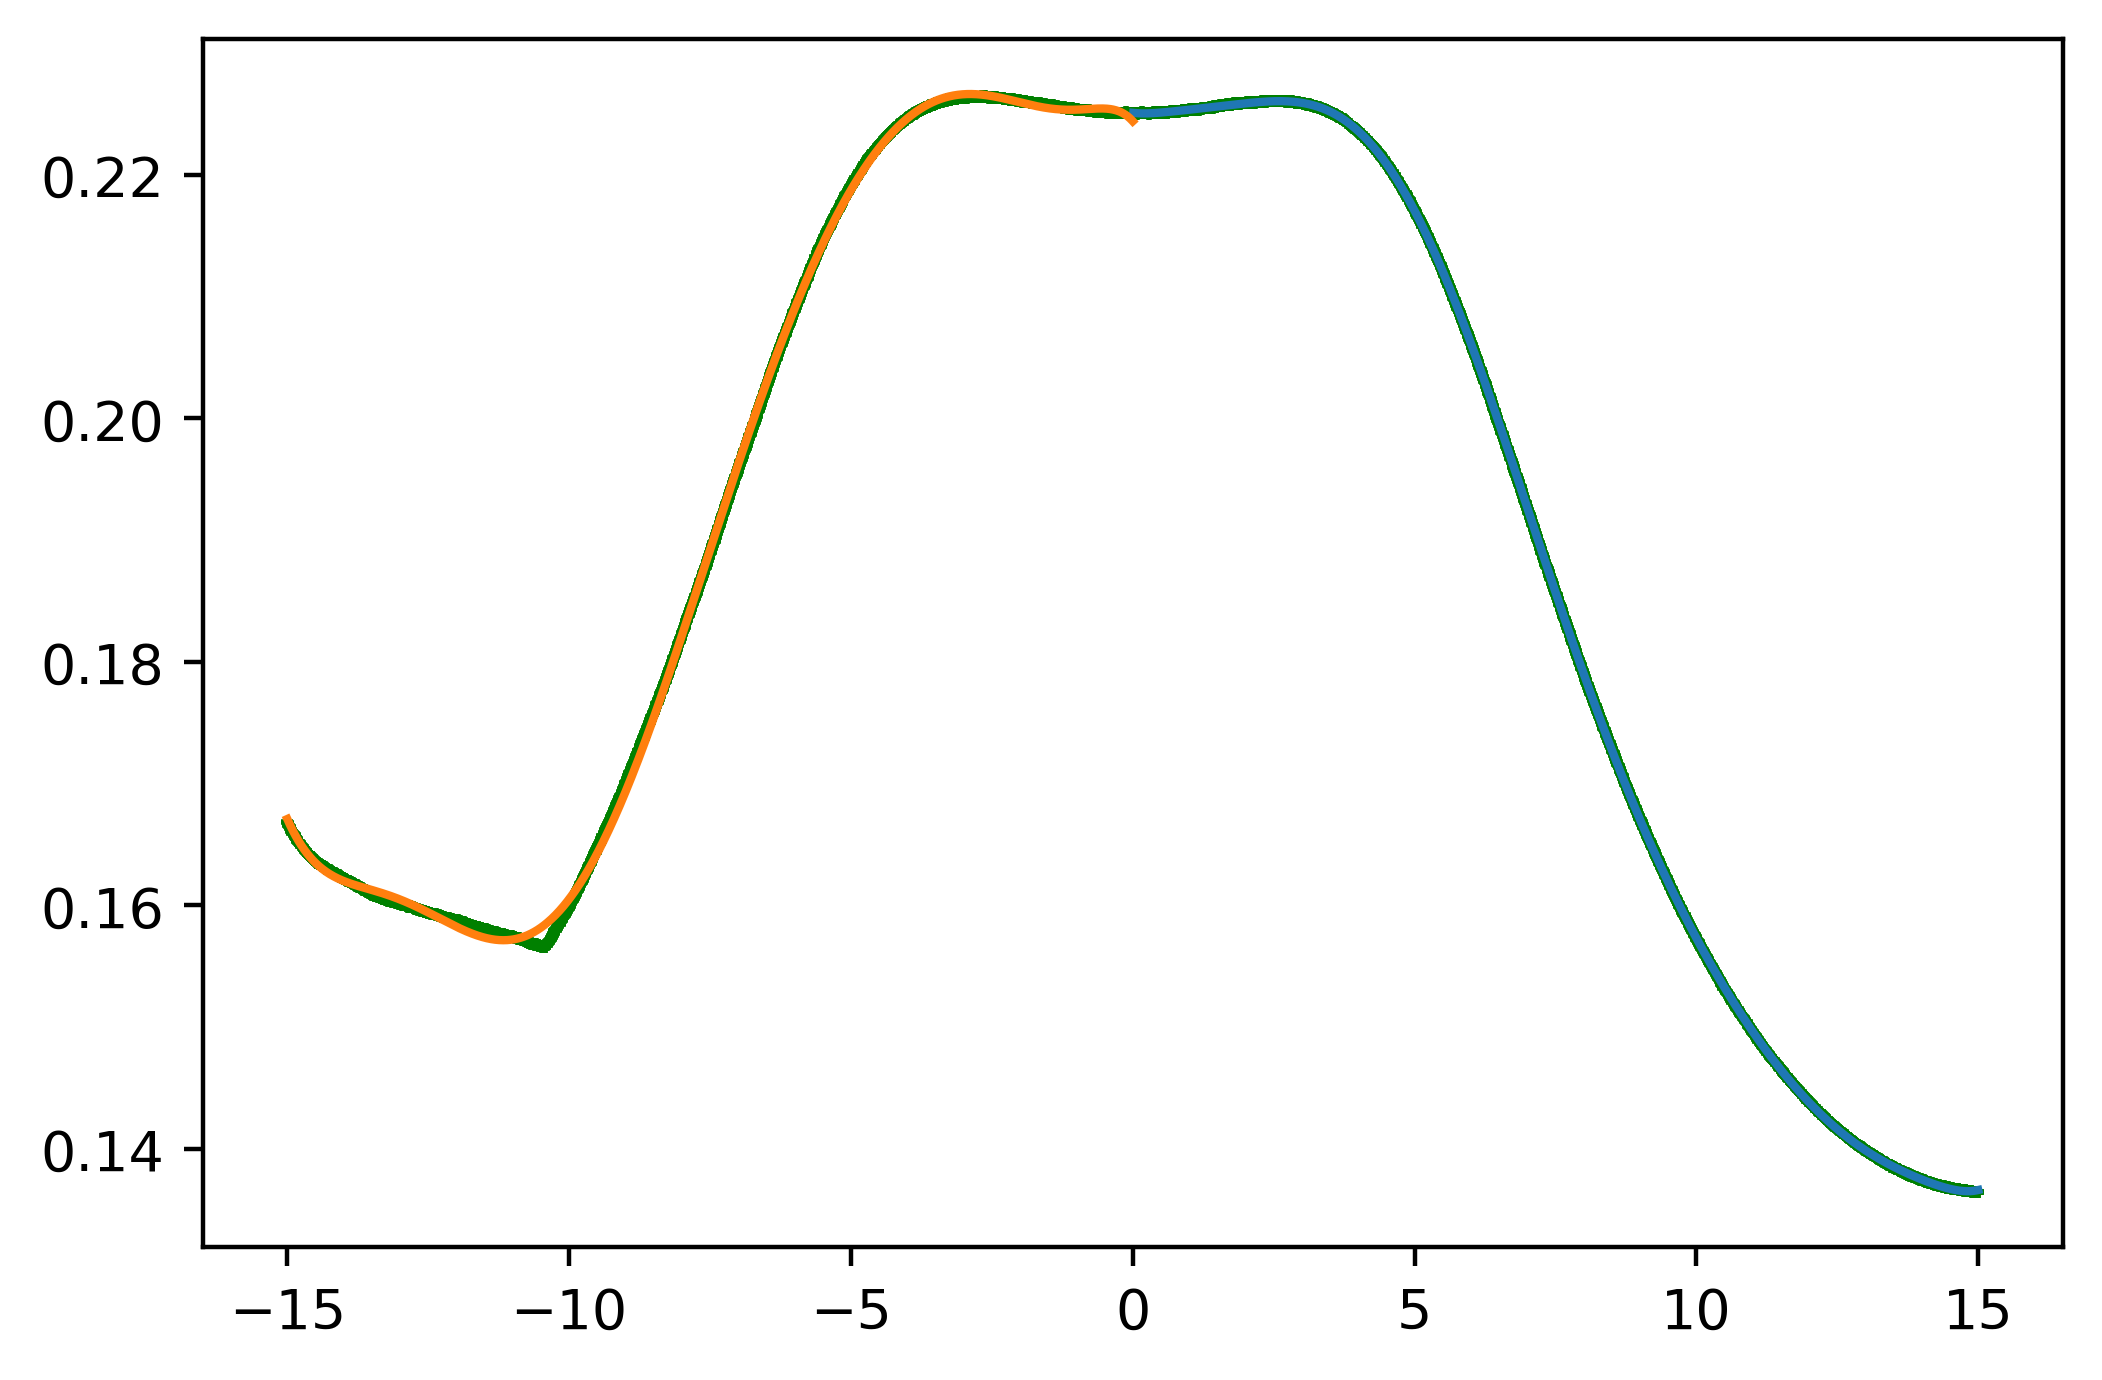

In [34]:
plt.figure(dpi=400)
plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

### 90 degrees

In [ ]:
vp90 = pd.read_csv('./2019-06-28/5vp90_daedalus_radialPolar_calib_A000.0_2019-06-28_1.csv', comment='#')
vn90 = pd.read_csv('./2019-06-28/5vn90_daedalus_radialPolar_calib_A000.0_2019-06-28_1.csv', comment='#')

In [ ]:
vp90 = vp90.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp90 = vp90.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Yfield)*180/np.pi)
vp90 = vp90.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vn90 = vn90.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn90 = vn90.assign(theta=lambda a: np.arctan2(a.Zfield, a.Yfield)*180/np.pi)
vn90 = vn90.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vp90_dv = {}
vn90_dv = {}
for c in vp90.columns[:]:
    vp90_dv[c] = (["R"],vp90[c])
    vn90_dv[c] = (["R"],vn90[c])
vp90_ds = xr.Dataset(vp90_dv)
vn90_ds = xr.Dataset(vn90_dv)

In [ ]:
vp90.plot('R', 'theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

In [ ]:
vn90.plot('R', 'theta')
plt.axhline(-90,color='r')
plt.axhline(90, color='r')
plt.axvline(0,color='orange')

In [ ]:
vp90_rp = vp90[vp90.R>0]
vp90_rn = vp90[vp90.R<0]
vn90_rp = vn90[vn90.R>0]
vn90_rn = vn90[vn90.R<0]

In [ ]:
plt.plot(vp_rp.R, vp_rp.theta)
plt.plot(vp_rn.R, vp_rn.theta)

### Plot pos neg voltage discrepancy

In [ ]:
plt.plot(vp.R, (vp.theta+vn.theta))

### Voltage Correction function

In [36]:
V0 = 5.0 # Voltage used for radial scan
Rpts_p = np.arange(0, 15, 0.01)
Rpts_n = np.arange(-15, 0, 0.01)

In [37]:
vcent_vp_rp = V0/cen_vp_fit(bmag_vp_rp(Rpts_p))
vcent_vp_rn = V0/cen_vp_fit(bmag_vp_rn(Rpts_n))
vcent_vn_rp = -V0/cen_vn_fit(-bmag_vn_rp(Rpts_p))
vcent_vn_rn = -V0/cen_vn_fit(-bmag_vn_rn(Rpts_n))

In [38]:
n = 10
vcorr_vp_rp_coeff = np.polyfit(Rpts_p, vcent_vp_rp, n)
vcorr_vp_rp = np.poly1d(vcorr_vp_rp_coeff)
vcorr_vp_rn_coeff = np.polyfit(Rpts_n, vcent_vp_rn, n)
vcorr_vp_rn = np.poly1d(vcorr_vp_rn_coeff)
vcorr_vn_rp_coeff = np.polyfit(Rpts_p, vcent_vn_rp, n)
vcorr_vn_rp = np.poly1d(vcorr_vn_rp_coeff)
vcorr_vn_rn_coeff = np.polyfit(Rpts_n, vcent_vn_rn, n)
vcorr_vn_rn = np.poly1d(vcorr_vn_rn_coeff)

In [39]:
print(vcorr_vp_rp_coeff, '\n', vcorr_vp_rn_coeff, '\n', vcorr_vn_rp_coeff, '\n',vcorr_vn_rn_coeff)

[ 1.06894022e-09 -8.40541456e-08  2.79124005e-06 -5.06102129e-05
  5.39946066e-04 -3.40463809e-03  1.23152179e-02 -2.59799884e-02
  3.07008049e-02 -1.30873530e-02 -1.05104199e+00] 
 [ 1.95410690e-10  2.27779784e-08  9.85154810e-07  2.15398435e-05
  2.61742239e-04  1.78324171e-03  6.58612452e-03  1.39295977e-02
  1.70230071e-02  5.71503251e-03 -1.05194789e+00] 
 [ 1.01373603e-09 -7.88460322e-08  2.58732724e-06 -4.63053763e-05
  4.86969179e-04 -3.02206764e-03  1.07330451e-02 -2.20833336e-02
  2.52822349e-02 -1.03276615e-02 -9.60383393e-01] 
 [-2.05639136e-09 -1.60403574e-07 -5.25605588e-06 -9.44932678e-05
 -1.02393150e-03 -6.92735823e-03 -2.90550953e-02 -7.02067005e-02
 -8.65131932e-02 -4.71602244e-02 -9.67360235e-01]


In [40]:
vcorr_coeffs = [vcorr_vp_rp_coeff, vcorr_vn_rp_coeff, vcorr_vp_rn_coeff, vcorr_vn_rn_coeff]
np.savetxt("./icarusCalibCsv/icarus_volt_correction_calib.csv", vcorr_coeffs, delimiter=",")

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

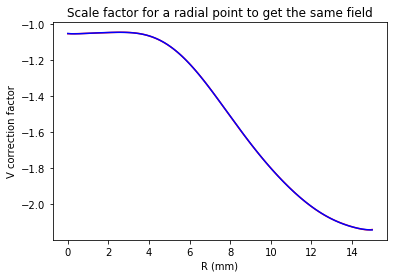

In [41]:
plt.plot(Rpts_p, vcent_vp_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vp_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

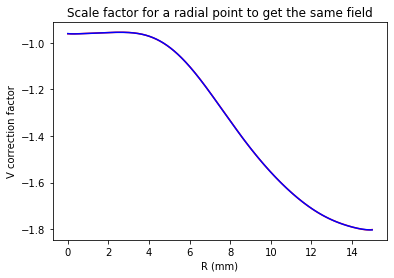

In [42]:
plt.plot(Rpts_p, vcent_vn_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vn_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')